## Grayworld

In [1]:
from __future__ import division, absolute_import, print_function, unicode_literals
import cv2
import numpy as np
from skimage import io

def white_balance_loops(img):
    result = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    for x in range(result.shape[0]):
        for y in range(result.shape[1]):
            l, a, b = result[x, y, :]
            # fix for CV correction
            l *= 100 / 255.0
            result[x, y, 1] = a - ((avg_a - 128) * (l / 100.0) * 1.1)
            result[x, y, 2] = b - ((avg_b - 128) * (l / 100.0) * 1.1)
    result = cv2.cvtColor(result, cv2.COLOR_LAB2BGR)
    return result

In [2]:
### white balance
from skimage import io
from matplotlib import pyplot as plt
import scipy.ndimage
import sys

def apply_mask(matrix, mask, fill_value):
    masked = np.ma.array(matrix, mask=mask, fill_value=fill_value)
    return masked.filled()

def apply_threshold(matrix, low_value, high_value):
    low_mask = matrix < low_value
    matrix = apply_mask(matrix, low_mask, low_value)

    high_mask = matrix > high_value
    matrix = apply_mask(matrix, high_mask, high_value)

    return matrix

def simplest_cb(img, percent=1):
    assert img.shape[2] == 3
    assert percent > 0 and percent < 100

    half_percent = percent / 200.0

    channels = cv2.split(img)

    out_channels = []
    for channel in channels:
        assert len(channel.shape) == 2
        # find the low and high precentile values (based on the input percentile)
        height, width = channel.shape
        vec_size = width * height
        flat = channel.reshape(vec_size)

        assert len(flat.shape) == 1

        flat = np.sort(flat)

        n_cols = flat.shape[0]

        low_val  = flat[math.floor(n_cols * half_percent)]
        high_val = flat[math.ceil( n_cols * (1.0 - half_percent))]

        # saturate below the low percentile and above the high percentile
        thresholded = apply_threshold(channel, low_val, high_val)
        # scale the channel
        normalized = cv2.normalize(thresholded, thresholded.copy(), 0, 255, cv2.NORM_MINMAX)
        out_channels.append(normalized)

    return cv2.merge(out_channels)

## Landmark detection & Target Finding

In [3]:
import cv2
import dlib
import numpy
import matplotlib.pyplot as plt
import math
import io

In [4]:
PREDICTOR_PATH = r"C:\Users\82107\Desktop\CatchTone-master\shape_predictor_68_face_landmarks.dat\shape_predictor_68_face_landmarks.dat"

In [5]:
SCALE_FACTOR = 1 
FEATHER_AMOUNT = 11

FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))

# Points used to line up the images.
ALIGN_POINTS = (LEFT_BROW_POINTS + RIGHT_EYE_POINTS + LEFT_EYE_POINTS +
                               RIGHT_BROW_POINTS + NOSE_POINTS + MOUTH_POINTS)

In [6]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)

In [7]:
class TooManyFaces(Exception):
    pass

In [8]:
class NoFaces(Exception):
    pass

In [9]:
def annotate_landmarks(im, landmarks):
    im = im.copy()
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(im, str(idx), pos,
                    fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                    fontScale=0.4,
                    color=(0, 0, 255))
        cv2.circle(im, pos, 3, color=(0, 255, 255))
    return im

In [10]:
def read_im_and_landmarks(fname):
    im = cv2.imread(fname, cv2.IMREAD_COLOR)
    im = cv2.resize(im, (im.shape[1] * SCALE_FACTOR, im.shape[0] * SCALE_FACTOR))
    landmarks = get_landmarks(im)

    return im, landmarks

In [11]:
def get_landmarks(im):
    rects = detector(im, 1)
    
    if len(rects) > 1:
        raise TooManyFaces
    if len(rects) == 0:
        raise NoFaces
        
    return numpy.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])

In [12]:
filename = "dark"
img_type = "jpg" ## jpg or png etc...

In [13]:
im, landmarks = read_im_and_landmarks(r"C:\Users\82107\Desktop\CatchTone-master\KakaoTalk_20190910_220013777.jpg")

im_annotated = annotate_landmarks(im, landmarks)

cv2.imwrite(r"C:\Users\82107\Desktop\CatchTone-master\result\\" + filename + "_landmarks.jpg", im_annotated) # save landmarked image file as ~_landmarks.jpg

True

In [14]:
color_location1 = ((landmarks[54]+landmarks[11]+landmarks[45])/3).astype(int) # left cheek
color_location2 = ((landmarks[48]+landmarks[4]+landmarks[36])/3).astype(int) # right cheek

rgb1 = im[color_location1[0, 1], color_location1[0, 0]][2], im[color_location1[0, 1], color_location1[0, 0]][1], im[color_location1[0, 1], color_location1[0, 0]][0]
rgb2 = im[color_location2[0, 1], color_location2[0, 0]][2], im[color_location2[0, 1], color_location2[0, 0]][1], im[color_location2[0, 1], color_location2[0, 0]][0]

rgb = ((int(rgb1[0])+int(rgb2[0]))/2, (int(rgb1[1])+int(rgb2[1]))/2, (int(rgb1[2])+int(rgb2[2]))/2)

In [15]:
cv2.putText(im, str("Target1"), (color_location1[0, 0]+5, color_location1[0, 1]),
                    fontFace=cv2.FONT_HERSHEY_TRIPLEX,
                    fontScale=0.5,
                    color=(0, 0, 255))
cv2.circle(im, (color_location1[0, 0], color_location1[0, 1]), 3, color=(0, 0, 255), thickness = -1)

cv2.putText(im, str("Target2"), (color_location2[0, 0]+5, color_location2[0, 1]),
                    fontFace=cv2.FONT_HERSHEY_TRIPLEX,
                    fontScale=0.5,
                    color=(0, 0, 255))
cv2.circle(im, (color_location2[0, 0], color_location2[0, 1]), 3, color=(0, 0, 255), thickness = -1)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[ 26,  21,  22],
        [ 26,  21,  22],
        [ 27,  22,  23],
        ...,
        [ 31,  23,  24],
        [ 28,  21,  18],
        [ 33,  27,  22]],

       [[ 29,  23,  24],
        [ 24,  19,  20],
        [ 24,  19,  20],
        ...,
        [ 31,  23,  23],
        [ 27,  19,  19],
        [ 40,  32,  32]],

       [[ 26,  21,  20],
        [ 25,  19,  20],
        [ 25,  20,  21],
        ...,
        [ 30,  22,  23],
        [ 29,  21,  21],
        [ 32,  25,  22]]

In [16]:
im_annotated = annotate_landmarks(im, landmarks)

In [17]:
cv2.imwrite(r"C:\Users\82107\Desktop\CatchTone-master\result\\" + filename + "_target.jpg", im_annotated)

True

## a\* b\* value comparison

In [18]:
im = cv2.imread(r"C:\Users\82107\Desktop\CatchTone-master\result\dark_target.jpg")
lab_colors = cv2.cvtColor(im, cv2.COLOR_BGR2LAB)

In [19]:
lab_colors

array([[[255, 128, 128],
        [255, 128, 128],
        [255, 128, 128],
        ...,
        [255, 128, 128],
        [255, 128, 128],
        [255, 128, 128]],

       [[255, 128, 128],
        [255, 128, 128],
        [255, 128, 128],
        ...,
        [255, 128, 128],
        [255, 128, 128],
        [255, 128, 128]],

       [[255, 128, 128],
        [255, 128, 128],
        [255, 128, 128],
        ...,
        [255, 128, 128],
        [255, 128, 128],
        [255, 128, 128]],

       ...,

       [[ 19, 130, 124],
        [ 18, 130, 124],
        [ 17, 130, 125],
        ...,
        [ 23, 130, 123],
        [ 18, 128, 122],
        [ 23, 128, 123]],

       [[ 18, 130, 124],
        [ 17, 130, 124],
        [ 17, 130, 125],
        ...,
        [ 18, 130, 122],
        [ 19, 128, 122],
        [ 27, 128, 123]],

       [[ 16, 130, 124],
        [ 16, 130, 124],
        [ 16, 130, 125],
        ...,
        [ 23, 130, 123],
        [ 17, 130, 122],
        [ 23, 128, 123]]

In [20]:
a_value1 = lab_colors[color_location1[0, 1], color_location1[0, 0]][1]
a_value2 = lab_colors[color_location2[0, 1], color_location2[0, 0]][1]

a_value = (int(a_value1) + int(a_value2))/2

In [21]:
b_value1 = lab_colors[color_location1[0, 1], color_location1[0, 0]][2]
b_value2 = lab_colors[color_location2[0, 1], color_location2[0, 0]][2]

b_value = (int(b_value1) + int(b_value2))/2

In [25]:
#from sklearn.externals import joblib
import joblib

In [32]:
loaded_model = joblib.load(r"C:\Users\82107\Desktop\CatchTone-master\CatchTone-master\classifier.sav")

In [33]:
skin_ab_value = []

info = []
info.append(a_value)
info.append(b_value)

skin_ab_value.append(info)

In [34]:
def warm_or_cool(skin_ab_value):
    value = loaded_model.predict(skin_ab_value)
    
    if value == 0:
        return "warm"
    else:
        return "cool"

In [35]:
skin_ab_value

[[207.0, 195.0]]

(120.0, 170.0)

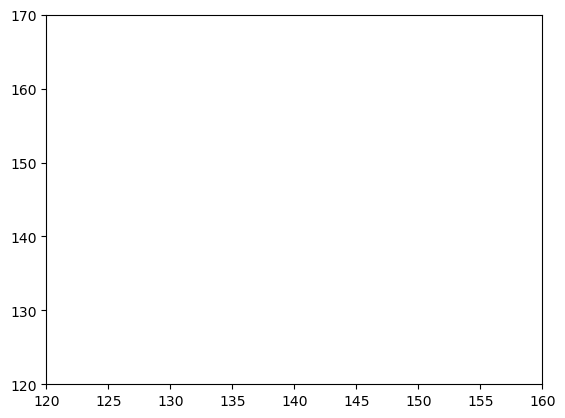

In [36]:
import matplotlib.pyplot as plt

plt.xlim(120, 160)
plt.ylim(120, 170)

## Extracting Eye Area

In [37]:
def cut_eyes(im,landmarks):
    im = im[landmarks[37][0, 1]+1:landmarks[40][0, 1]+1, landmarks[37][0, 0]-2:landmarks[38][0, 0]+3, :]
    
    return im

In [38]:
cut_eyes = cut_eyes(im, landmarks)

In [40]:
cv2.imwrite(r"C:\Users\82107\Desktop\CatchTone-master\result\\" + filename + "_eye.jpg", cut_eyes)

True

## Pupil & Light (on Eye) Detection

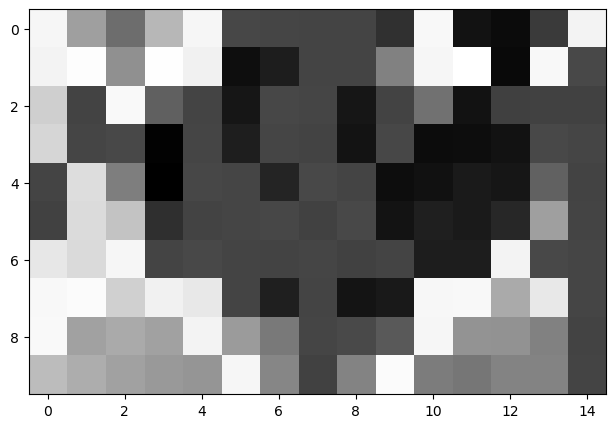

In [41]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
gray = cv2.cvtColor(cut_eyes, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 5))
plt.imshow(gray, cmap='gray')

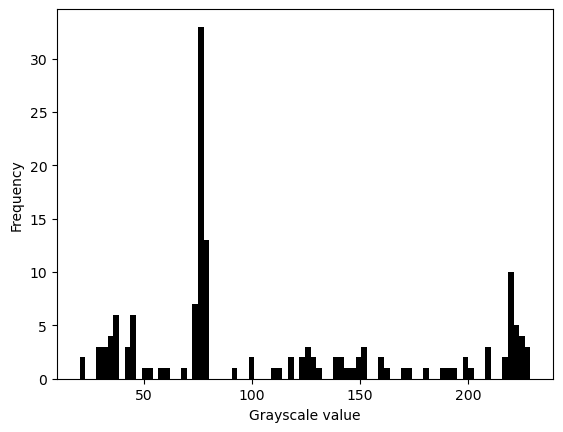

In [42]:
import numpy as np
import matplotlib.pyplot as plt

gray_resized = np.resize(gray, [gray.shape[0]*gray.shape[1]])
n, bins, patches = plt.hist(gray_resized, bins=80, color='black')

plt.xlabel("Grayscale value")
plt.ylabel("Frequency")
plt.show()

### 1) Assuming Dark Eyes

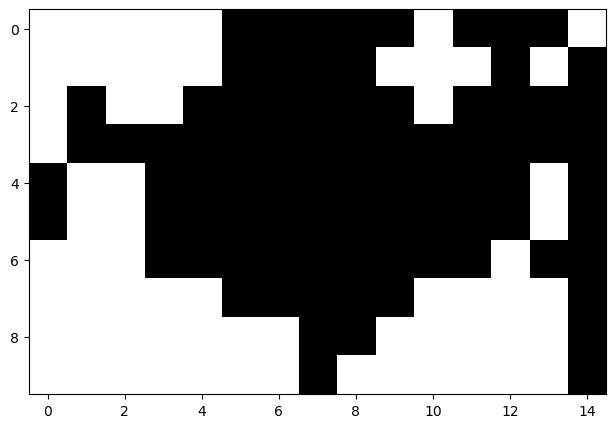

In [43]:
#Light on eye Detection (thresh = 90)

etval, thresholded = cv2.threshold(gray, 90, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 5))
plt.imshow(thresholded, cmap='gray')

In [44]:
index_dark = []

In [45]:
i = 0

while i < cut_eyes.shape[0]:
    j = 0
    index_of_black = []
    while j < cut_eyes.shape[1]:
        if thresholded[i][j] == 0:
            index_of_black.append(i)
            index_of_black.append(j)
            index_dark.append(index_of_black)
            index_of_black = []
        j += 1
    i += 1

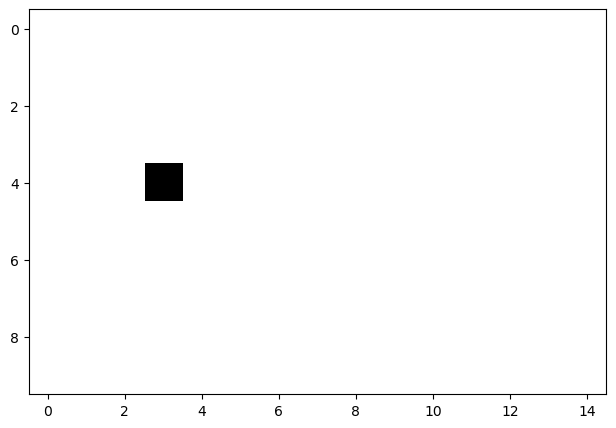

In [46]:
# Pupil Detection (thresh = 20)
etval, thresholded = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 5))
plt.imshow(thresholded, cmap='gray')

In [47]:
i = 0

while i < cut_eyes.shape[0]:
    j = 0
    index_deleted = []
    while j < cut_eyes.shape[1]:
        if thresholded[i][j] == 0:
            index_deleted.append(i)
            index_deleted.append(j)
            if index_deleted in index_dark:
                index_dark.remove(index_deleted)
            index_deleted = []
        j += 1
    i += 1

### 2) Assuming Medium Brightness Eyes

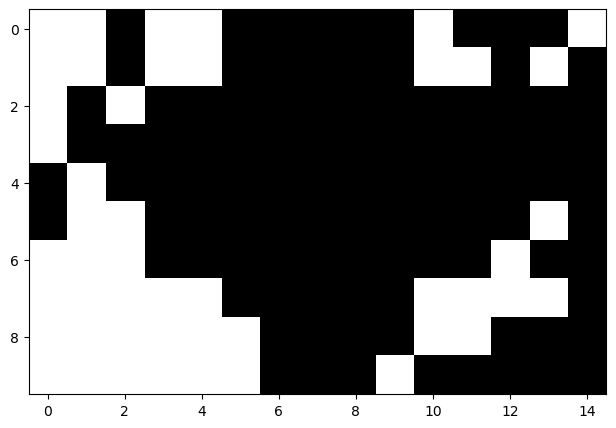

In [48]:
#Light on eye Detection (thresh = 140)

etval, thresholded = cv2.threshold(gray, 140, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 5))
plt.imshow(thresholded, cmap='gray')

In [49]:
index_medium = []

In [50]:
i = 0

while i < cut_eyes.shape[0]:
    j = 0
    index_of_black = []
    while j < cut_eyes.shape[1]:
        if thresholded[i][j] == 0:
            index_of_black.append(i)
            index_of_black.append(j)
            index_medium.append(index_of_black)
            index_of_black = []
        j += 1
    i += 1

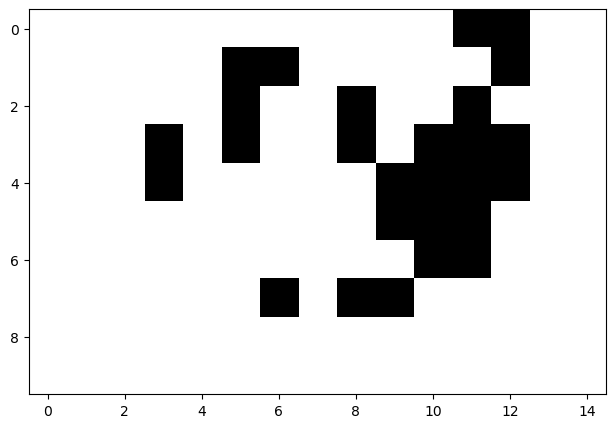

In [51]:
# Pupil Detection (thresh = 50)
etval, thresholded = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 5))
plt.imshow(thresholded, cmap='gray')

In [52]:
i = 0

while i < cut_eyes.shape[0]:
    j = 0
    index_deleted = []
    while j < cut_eyes.shape[1]:
        if thresholded[i][j] == 0:
            index_deleted.append(i)
            index_deleted.append(j)
            if index_deleted in index_medium:
                index_medium.remove(index_deleted)
            index_deleted = []
        j += 1
    i += 1

### 3) Assuming Light Eyes

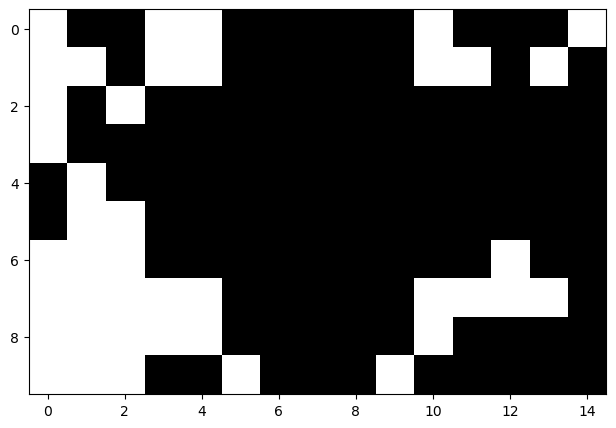

In [53]:
#Light on eye Detection (thresh = 140)

etval, thresholded = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 5))
plt.imshow(thresholded, cmap='gray')

In [54]:
index_light = []

In [55]:
i = 0

while i < cut_eyes.shape[0]:
    j = 0
    index_of_black = []
    while j < cut_eyes.shape[1]:
        if thresholded[i][j] == 0:
            index_of_black.append(i)
            index_of_black.append(j)
            index_light.append(index_of_black)
            index_of_black = []
        j += 1
    i += 1

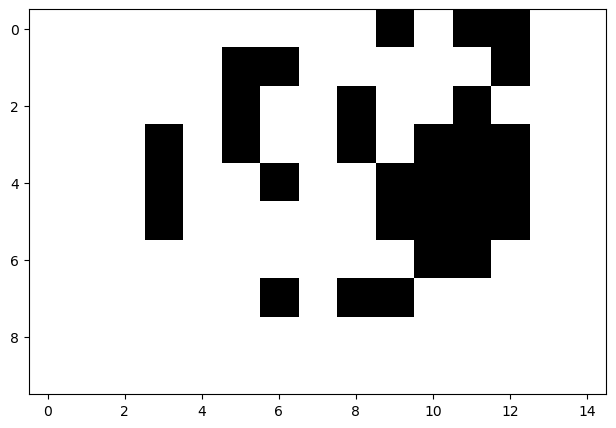

In [56]:
# Pupil Detection (thresh = 50)
etval, thresholded = cv2.threshold(gray, 65, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 5))
plt.imshow(thresholded, cmap='gray')

In [57]:
i = 0

while i < cut_eyes.shape[0]:
    j = 0
    index_deleted = []
    while j < cut_eyes.shape[1]:
        if thresholded[i][j] == 0:
            index_deleted.append(i)
            index_deleted.append(j)
            if index_deleted in index_light:
                index_light.remove(index_deleted)
            index_deleted = []
        j += 1
    i += 1

### 4) Selecting which index to use

In [58]:
print("Length of index_dark : " + str(len(index_dark)))
print("Length of index_medium : " + str(len(index_medium)))
print("Length of index_light : " + str(len(index_light)))

Length of index_dark : 84
Length of index_medium : 75
Length of index_light : 77


In [59]:
def select_index_to_use():
    max = 0
    name_of_index = ""
    index_to_use = []
    
    if len(index_dark) > len(index_medium):
        max = len(index_dark)
        index_to_use = index_dark
        name_of_index = "index_dark"
    else:
        max = len(index_medium)
        index_to_use = index_medium
        name_of_index = "index_medium"
        
    
    if max < len(index_light):
        print("index_light")
        index_to_use = index_light
    else:
        print(name_of_index)
        
    return index_to_use

In [60]:
index_to_use = select_index_to_use()

index_dark


## L\*value of Eye (15% is 0)

In [61]:
eye_lab = cv2.cvtColor(cut_eyes, cv2.COLOR_RGB2LAB)
eye_l_value = []

i = 0
while i < len(index_to_use):
    eye_l_value.append(eye_lab[index_to_use[i][0], index_to_use[i][1], 0])
    i += 1

In [62]:
i = 0
while i < int(len(eye_l_value)*15/85):
    eye_l_value.append(0)
    i += 1

In [63]:
print("You are \"" + warm_or_cool(skin_ab_value) + "\" tone.")

You are "cool" tone.


In [64]:
eye_l_value = np.array(eye_l_value)
std = math.sqrt(np.sum((eye_l_value - np.mean(eye_l_value))**2)/(eye_l_value.size))

eye_brightness = ""

if std < 38.28:
    eye_brightness = "dark"
else:
    eye_brightness = "light"

In [65]:
def season_matching(skin_tone, eye_brightness):
    if skin_tone == "warm":
        if eye_brightness == "dark":
            return "autumn"
        else:
            return "spring"
    else:
        if eye_brightness == "dark":
            return "winter"
        else:
            return "summer"

In [66]:
season = season_matching(warm_or_cool(skin_ab_value), eye_brightness)

## Deep? Mute? Light? Bright?

In [67]:
color_info = [[0.87464539937997 * 255, 181, 'vivid'],
 [0.6920954876849125 * 255, 207, 'bright'],
 [0.8348038859274655 * 255, 170, 'strong'],
 [0.8901501134915047 * 255, 137, 'deep'],
 [0.3300064593086124 * 255, 221, 'light'],
 [0.39800595815638706 * 255, 182, 'soft'], 
 [0.5135643825656158 * 255, 142, 'dull'],
 [0.6815737217178439 * 255, 93, 'dark'],
 [0.11073418459625402 * 255, 226, 'pale'],
 [0.22483614835441365 * 255, 110, 'grayish'],
 [0.26913149326755986 * 255, 58, 'dark_grayish'],
 [0.20022609113608203 * 255, 186, 'light_grayish']]

In [68]:
spring_list = []
spring_list.append(color_info[0])
spring_list.append(color_info[1])
spring_list.append(color_info[4])
spring_list.append(color_info[8])

In [69]:
summer_list = []
summer_list.append(color_info[4])
summer_list.append(color_info[8])
summer_list.append(color_info[5])
summer_list.append(color_info[6])
summer_list.append(color_info[7])
summer_list.append(color_info[9])
summer_list.append(color_info[10])
summer_list.append(color_info[11])

In [70]:
autumn_list = []
autumn_list.append(color_info[3])
autumn_list.append(color_info[5])
autumn_list.append(color_info[6])
autumn_list.append(color_info[9])
autumn_list.append(color_info[3])
autumn_list.append(color_info[7])

In [71]:
winter_list = []
winter_list.append(color_info[0])
winter_list.append(color_info[2])
winter_list.append(color_info[3])
winter_list.append(color_info[7])
winter_list.append(color_info[10])

In [72]:
skin_v_value = max(rgb[0], rgb[1], rgb[2])
skin_s_value = (1-min(rgb[0], rgb[1], rgb[2])/skin_v_value) * 255

In [73]:
skin_s_value, skin_v_value

(78.55172413793105, 217.5)

In [74]:
def pccs_finder(season, s, v):
    i = 0
    min = 2000
    skin_type = ""
    
    if season == "spring":
        while i < len(spring_list):
            distance = math.sqrt((s - spring_list[i][0])**2 + (v - spring_list[i][1])**2)
            print(distance)
            if min > distance:
                min = distance
                print("Calculating... " + spring_list[i][2] + " : " + str(distance))
                skin_type = spring_list[i][2]
        
            i += 1
    
    elif season == "summer":
        while i < len(summer_list):
            distance = math.sqrt((s - summer_list[i][0])**2 + (v - summer_list[i][1])**2)
            print(distance)
            if min > distance:
                min = distance
                print("Calculating... " + summer_list[i][2] + " : " + str(distance))
                skin_type = summer_list[i][2]
        
            i += 1
            
    elif season == "autumn":
        while i < len(autumn_list):
            distance = math.sqrt((s - autumn_list[i][0])**2 + (v - autumn_list[i][1])**2)
            print(distance)
            if min > distance:
                min = distance
                print("Calculating... " + autumn_list[i][2] + " : " + str(distance))
                skin_type = autumn_list[i][2]
        
            i += 1
    
    else:
        while i < len(winter_list):
            distance = math.sqrt((s - winter_list[i][0])**2 + (v - winter_list[i][1])**2)
            if min > distance:
                min = distance
                print("Calculating... " + winter_list[i][2] + " : " + str(distance))
                skin_type = winter_list[i][2]
        
            i += 1
    
    return skin_type

In [75]:
pccs = pccs_finder(color_info, skin_s_value, skin_v_value)

Calculating... vivid : 149.02196054768095
Calculating... strong : 142.4745240270146


In [76]:
print("You are " + pccs + " \"" + season+"\"")

You are strong "winter"


In [77]:
skin_ab_value

[[207.0, 195.0]]